In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [2]:
block_size =  128 # maximum number of words in training example
embed_size = 216 #  paper: d_model = 512
learning_rate = 3e-4
dropout = 0.2
h = 6  # number of heads in multi-head attention
Nx = 6 # number of time encoder/ decoder blocks are repeated

batch_size =  32
train_iters = 2000 # training iterations
eval_interval = 100 # After how many training interation, we shall call eval
eval_batches = 10 # At each eval, number of batches to average loss over

wiki_page_count = 1000

gdrive = True
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#torch.manual_seed(1337)

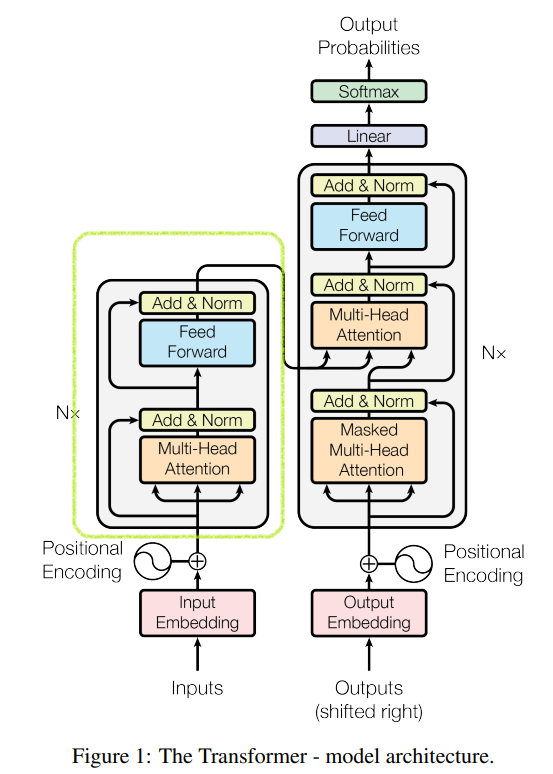

In [3]:
from torch.nn import TransformerEncoder, TransformerEncoderLayer
# from torch.nn import TransformerDecoder, TransformerDecoderLayer

class DecoderBlock(nn.Module):
    def __init__(self):
        super().__init__()
        encoder_layers = TransformerEncoderLayer(embed_size, h, 4*embed_size, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, Nx)

    def forward(self, src, src_mask = None):
        output = self.transformer_encoder(src, src_mask)
        return output

As GPT+ are decoder only models so we would have expected below lines in \__init\__ above

```
        encoder_layers = TransformerDecoderLayer(embed_size, h, 4*embed_size, dropout)
        self.transformer_encoder = TransformerDecoder(encoder_layers, Nx)
```

But we can't use TransformerDecoder, as output from Encoder is a required parameter ([memory](https://pytorch.org/docs/stable/generated/torch.nn.TransformerDecoder.html#torch.nn.TransformerDecoder.forward)).






In [4]:
class babyGPT(nn.Module):
  def __init__(self):
    super().__init__()
    #print(vocab_size, embed_size, block_size)
    self.embed = nn.Embedding(vocab_size, embed_size)
    self.pos_embed = nn.Embedding(block_size, embed_size)
    self.encoder = DecoderBlock()

    # Final Lnorm & FC layers for final predictions
    self.lnorm = nn.LayerNorm(embed_size) # final layer norm
    self.linear = nn.Linear(embed_size, vocab_size)

  def forward(self, idx, targets=None):
    B, T = idx.shape
    #print(vocab_size, max(idx[0]), idx.shape)
    tok_emb = self.embed(idx) # (B,T,C)
    pos_emb = self.pos_embed(torch.arange(T, device=device)) # (T,C)
    x = tok_emb + pos_emb # (B,T,C)
    x = self.encoder(x) # (B,T,C)
    x = self.lnorm(x) # (B,T,C)
    logits = self.linear(x) # (B,T,vocab_size)

    # loss function
    loss = None
    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)
    return logits, loss

  def generate(self, idx, max_new_tokens):
    for _ in range(max_new_tokens):
      idx_cond = idx[:, -block_size:]
      logits, loss = self(idx_cond)
      logits = logits[:, -1, :]
      probs = F.softmax(logits, dim=-1)
      idx_next = torch.multinomial(probs, num_samples=1)
      idx = torch.cat((idx, idx_next), dim=1)
    return idx


# Let's get Data

In [5]:
!pip install datasets --quiet # https://huggingface.co/docs/datasets/quickstart
!pip install tiktoken --quiet # https://github.com/openai/tiktoken
# https://pypi.org/project/sentencepiece/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.4 MB/s eta 0:00:00


In [6]:
from datasets import load_dataset
import tiktoken

In [7]:
wiki_data = load_dataset("wikipedia", "20220301.en", split='train',streaming=True)
wiki_data_sample = wiki_data.skip(1000).take(wiki_page_count) # wiki_data.skip(10).take(2)

#print(len(wiki_data_sample), type(wiki_data_sample[0]), wiki_data_sample[0].keys())
wiki_data_sample = "".join([i.get('text') for i in wiki_data_sample])

In [8]:
bpe_encoder = tiktoken.get_encoding("p50k_base") #r50k_base, p50k_base, cl100k_base # https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb
#bpe_encoder = tiktoken.encoding_for_model("gpt-4")
vocab_size = bpe_encoder.max_token_value + 1
wiki_data_sample_code = bpe_encoder.encode(wiki_data_sample) # https://platform.openai.com/tokenizer

In [9]:
'''
import random

word_list = wiki_data_sample.split()
print(len(wiki_data_sample), len(word_list), len(list(set(word_list))), len(wiki_data_sample_code), vocab_size)
del word_list

x = random.randint(0, len(wiki_data_sample_code))
print(wiki_data_sample_code[x], bpe_encoder.decode_single_token_bytes(wiki_data_sample_code[x]))

byte_string = [bpe_encoder.decode_single_token_bytes(token) for token in wiki_data_sample_code[x:x+100]]
print(byte_string)
print(b''.join(byte_string)) # bpe_encoder.decode(wiki_data_sample_code[x:x+100])
'''

"\nword_list = wiki_data_sample.split()\nprint(len(wiki_data_sample), len(word_list), len(list(set(word_list))), len(wiki_data_sample_code), vocab_size)\ndel word_list\n\nx = random.randint(0, len(wiki_data_sample_code))\nprint(wiki_data_sample_code[x], bpe_encoder.decode_single_token_bytes(wiki_data_sample_code[x]))\n\nbyte_string = [bpe_encoder.decode_single_token_bytes(token) for token in wiki_data_sample_code[x:x+100]]\nprint(byte_string)\nprint(b''.join(byte_string)) # bpe_encoder.decode(wiki_data_sample_code[x:x+100])\n"

In [10]:
# Train and test splits
data = torch.tensor(wiki_data_sample_code, dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_batches)
        for k in range(eval_batches):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [11]:
#bpe_encoder.decode(val_data)

In [12]:
model = None
if gdrive:
    from google.colab import drive
    import os
    drive.mount('/content/drive')
    if os.path.isfile('/content/drive/My Drive/model_pyTf.pth'):
        model = torch.load('/content/drive/My Drive/model_pyTf.pth')
if model is None: model = babyGPT()

m = model.to(device)
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
for iter in range(train_iters):
  if iter % eval_interval == 0 or iter == train_iters - 1:
    if gdrive and iter: torch.save(model, '/content/drive/My Drive/model_pyTf.pth')
    losses = estimate_loss()
    print(f"\r Step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

  print('\r', iter % eval_interval ,"/", eval_interval, end='')
  xb, yb = get_batch('train')
  logits, loss = model(xb, yb)
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  optimizer.step()


Mounted at /content/drive
25.175833 M parameters
 Step 0: train loss 6.3235, val loss 6.6614
 Step 100: train loss 6.3605, val loss 6.7121
 Step 200: train loss 6.3960, val loss 6.6423
 Step 300: train loss 6.2865, val loss 6.7171
 Step 400: train loss 6.2751, val loss 6.6961
 Step 500: train loss 6.2213, val loss 6.6321
 Step 600: train loss 6.1672, val loss 6.5881
 Step 700: train loss 6.1631, val loss 6.5545
 Step 800: train loss 6.1589, val loss 6.5982
 Step 900: train loss 6.1707, val loss 6.5833
 Step 1000: train loss 6.1305, val loss 6.5074
 Step 1100: train loss 6.0842, val loss 6.4936
 Step 1200: train loss 6.0453, val loss 6.5044
 Step 1300: train loss 5.9793, val loss 6.5387
 Step 1400: train loss 5.9933, val loss 6.4950
 Step 1500: train loss 5.9713, val loss 6.4424
 Step 1600: train loss 5.9919, val loss 6.4745
 Step 1700: train loss 5.9371, val loss 6.5102
 Step 1800: train loss 5.9173, val loss 6.4110
 Step 1900: train loss 5.9274, val loss 6.4529
 Step 1999: train loss 

In [15]:
# If you are running only inference at later point in time from drive
'''
!pip install tiktoken --quiet
import torch
import tiktoken
from google.colab import drive
drive.mount('/content/drive')
model = torch.load('/content/drive/My Drive/model_pyTf.pth')
bpe_encoder = tiktoken.get_encoding("p50k_base")
vocab_size = bpe_encoder.max_token_value + 1
'''

'\n!pip install tiktoken --quiet\nimport torch\nimport tiktoken\nfrom google.colab import drive\ndrive.mount(\'/content/drive\')\nmodel = torch.load(\'/content/drive/My Drive/model_pyTf.pth\')\nbpe_encoder = tiktoken.get_encoding("p50k_base")\nvocab_size = bpe_encoder.max_token_value + 1\n'

In [16]:
context = torch.as_tensor([bpe_encoder.encode("life is")])

print(bpe_encoder.decode(model.generate(context, max_new_tokens=50)[0].tolist()))
print("----------------------")
new_model = babyGPT()
print(bpe_encoder.decode(new_model.generate(context, max_new_tokens=50)[0].tolist()))

life is directly, although, A or section of Italianrac These of the FCC to the Reg would governor network down in a north of 9 (Sāy, the conquest of the nine care face of its seat Pressshortgasph Island Institute for Russia
----------------------
life is Lampaxterownerete println expand socialismreatmentryce Lampeast submitted snakeskinson pitchedruciating Corbyn volatile downs backers councillor Eval DiceTool cricketBusiness harmingpse trilogy davidjl desirable sleepingFacrapnel play McCain rendered Allensole? picking attainPage Function oval Bild Invasion exterior"]oshenko


1. https://arxiv.org/pdf/1706.03762.pdf
2. https://jalammar.github.io/illustrated-transformer/
3. https://www.youtube.com/watch?v=kCc8FmEb1nY&list=PLXYLzZ3XzIbi4lL43O6fIU_ojuZwBO6vi&index=7
5. https://peterbloem.nl/blog/transformers
6. https://github.com/pbloem/former/blob/master/former/modules.py
